In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import statistics

In [60]:
with open('pickles/df_four_counties_210115_laundry_revised.pickle','rb') as read_file:
    df = pickle.load(read_file)

---
---

data cleaning

---
---

-  city <span style="font-size:130%;color:green">✓</span>
    - all city names ok
    - value counts range from 798 - 1 -> will need some sort of transformation or 'other column'
-  zip <span style="font-size:130%;color:green">✓</span>
-  neighborhood <span style="font-size:130%;color:green">✓</span>
-  address_1 <span style="font-size:130%;color:green">✓</span>
    - drop datapoints where address is unknown
    - some apartment buildings have up to 16 units listed - probably need to adjust for this
-  address_2 <span style="font-size:130%;color:green">✓</span>
    - change to 1/0 for has unit# or doesn't
-  price <span style="font-size:130%;color:green">✓</span>
> 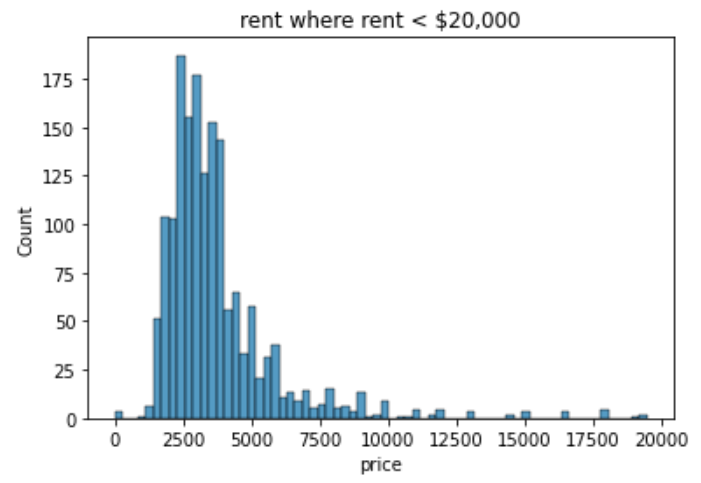
    - final price filter may change, but will set $20,000 for now
-  beds <span style="font-size:130%;color:green">✓</span>
> 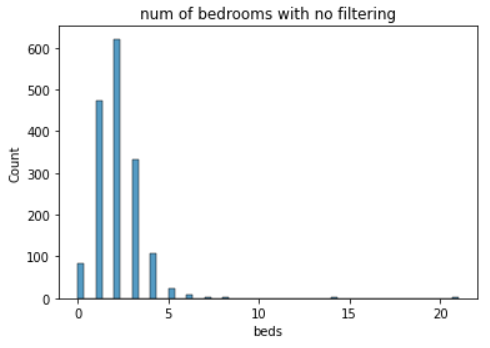
    - (circling back after bath column cleaning) remaining outlier has 14 beds, 1 bath  
    and actual listing indicates this is actually a 1BR unit. Will filter bedrooms on  
    less than 10 BRs (new actual max beds in this dataset will be 8)
-  baths <span style="font-size:130%;color:green">✓</span>
    - this column needs to be converted into baths + half_baths
    - filter out properties with 0 baths because .. what?! no baths?
-  half_baths <span style="font-size:130%;color:green">✓</span>
    - added this column with the baths column to create 'baths_incl_half'
    - filtered out properties with > 1 half bath (N = ~4) because two half baths != one  
    bathroom and couldn't figure out a good workaround
> 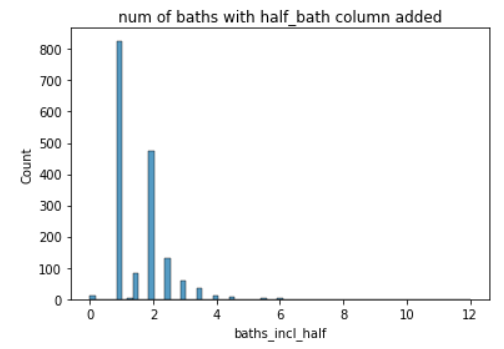
-  sq_footage <span style="font-size:130%;color:green">✓</span>
    - remove datapoints where sq_footage was not available (N = 265 ☹)
    - lots of ridiculously large sq footage values on 1BR apartments; filter for sq_footage < 5000  
    (there will still be some bad values, but there are a decent amount of real properties with sq  
    footage up to 5000)
> 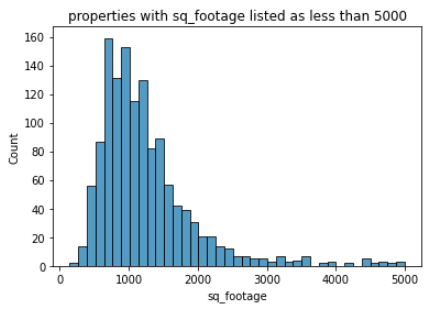
-  mls_num <span style="font-size:130%;color:green">✓</span>
    - use these to help identify and remove duplicate columns
    - code for no-duplicate-remaining-sanity-check:
> ```
(df_clean_in_prog
 .groupby(['address_1', 'address_2', 'zip', 'beds', 'baths', 'price','sq_footage'])
 .mls_num.count()
 .reset_index()
 .sort_values("mls_num", ascending=False))
```
-  furnished <span style="font-size:130%;color:green">✓</span>
    - there are only 7 furnished properties so...these will just get filtered out
-  mls_type <span style="font-size:130%;color:green">✓</span>
    - look how many ways there are to label an apartment as an apartment! SOS ☺
> 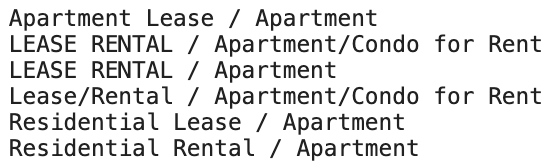
-  year_built
    - lots of missing values here, will impute using median
> 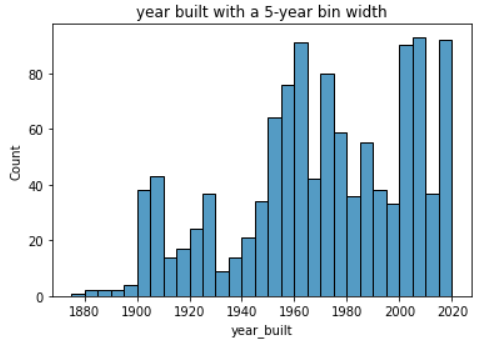
-  county
    - counts a little unbalanced, but otherwise clean
> 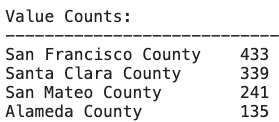
-  laundry_type
    - clean but will be an unreliable predictor since it was difficult to identify  
    laundry situations from rental listings
-  laundry_snippet
    - n/a
-  parking_spots
    - clean but lots of parking_unknown
-  parking_snippet

---

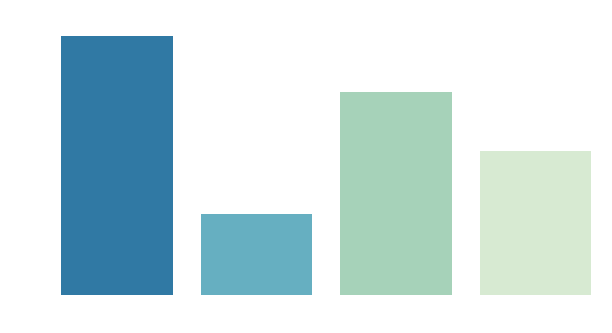

In [106]:
fig, ax = plt.subplots(figsize=(10, 5))
g = sns.barplot(x = ['San Francisco County', 'Alameda County', 'Santa Clara County', 'San Mateo County'], 
            y = [433, 135, 339, 241], palette = 'GnBu_r')

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.title.set_color('white')
plt.ylabel('Count')
plt.xlabel('County')
plt.title('Number of Datapoints by County')
g.figure.savefig('counties.svg')

In [61]:
df.county.unique()

<StringArray>
[      'Alameda County',                   <NA>, 'San Francisco County',
     'San Mateo County',   'Santa Clara County']
Length: 5, dtype: string

In [62]:
def feature_cleanliness_check(df, col_name):
    print('Value Counts:\n----------------------------')
    print(df[col_name].value_counts())
    sns.histplot(data = df, x = col_name);

In [63]:
print('data points - original df: ', df.shape[0])

df_duplicates_dropped = df.drop_duplicates()
# some properties are listed twice, but with one listing being incomplete.
# these duplicates get deleted entirely since it's not obvious which is
# the 'good' entry
df_remaining_address_duplicates_dropped = df.drop_duplicates(subset = ['address_1', 'address_2'], keep = False)
mask = (df.address_1 != 'unknown') & (df.price < 20000) & (df.half_baths < 2) & (df.baths < 10)\
& (df.baths != 0) & (df.beds < 10) & (df.sq_footage != 0) & (df.sq_footage < 5000) & (df.furnished != 'Fully Furnished')
# & (df.year_built != 0) & (df.year_built != '-')
df_clean_in_prog = df_remaining_address_duplicates_dropped[mask]

print('data points - clean in progress df: ', df_clean_in_prog.shape[0])
print('---\ntotal dropped datapoints: ', df.shape[0] - df_clean_in_prog.shape[0])

data points - original df:  1693
data points - clean in progress df:  1222
---
total dropped datapoints:  471


<ipython-input-63-4e6e80895b57>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean_in_prog = df_remaining_address_duplicates_dropped[mask]


In [66]:
df_clean = df_clean_in_prog.copy()
# 1 if has unit number, 0 if not
df_clean['has_address_2'] = [1 if i != 'N/A' else 0 for i in df_clean_in_prog.address_2]
df_clean.shape

# revised bath value
df_clean['baths_incl_half'] = df_clean_in_prog['baths'] + (df_clean_in_prog['half_baths']*0.5)
df_clean.shape

# cleaned mls types
clean_mls_types = ['apartment', 'condo', 'townhouse', 'single-family', 'house', 'detached', 'duplex', 'other rental property']
clean_mls = []
for mls_raw in df_clean_in_prog.mls_type:
    mls_low = mls_raw.lower()
    for clean_mls_type in clean_mls_types:
        found = False
        if clean_mls_type in mls_low:
            clean_mls.append(clean_mls_type)
            found = True
            break
    if found == False:
        clean_mls.append('other')
df_clean['clean_mls_types'] = clean_mls

# covert year to int and replace missing vals with 0 (to be filtered out later)
year_built = []
for year in df_clean.year_built:
    try:
        year_int = int(year)
    except ValueError:
        year_int = 0
    year_built.append(year_int)
    
non_zero_years = [i for i in year_built if i !=0]
median_year_built = statistics.median(non_zero_years)
year_built_imp = [i if i != 0 else median_year_built for i in year_built]

df_clean['year_built'] = year_built_imp
#df_clean = df_clean[df_clean.year_built != 0]
len(year_built_imp)

1222

In [68]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1222 entries, 0 to 1692
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   city             1222 non-null   string 
 1   zip              1222 non-null   string 
 2   neighborhood     1222 non-null   string 
 3   address_1        1222 non-null   string 
 4   address_2        1222 non-null   string 
 5   price            1222 non-null   float64
 6   beds             1222 non-null   float64
 7   baths            1222 non-null   float64
 8   half_baths       1222 non-null   float64
 9   sq_footage       1222 non-null   int64  
 10  mls_num          1222 non-null   string 
 11  furnished        1222 non-null   string 
 12  mls_type         1222 non-null   string 
 13  year_built       1222 non-null   float64
 14  county           1213 non-null   string 
 15  laundry_type     1222 non-null   object 
 16  laundry_snippet  1222 non-null   object 
 17  parking_spots 

> note that county has some nulls, but this feature will not be used in the model

---

it's me from the future! i found some bad address_1 entries that need to be deleted:

---

In [69]:
print(df_clean.shape)
df_clean = df_clean[(df_clean.address_1 != 'Northgate')
                   & (df_clean.address_1 != 'Newark')
                   & (df_clean.address_1 != '188 Minna')
                   & (df_clean.address_1 != '788 Minna')]
print(df_clean.shape)

(1222, 22)
(1209, 22)


In [70]:
with open('pickles/cleaned_210115_data_laundry_revised.pickle', 'wb') as to_write:
    pickle.dump(df_clean, to_write)

---
---

data vis

---
---

In [71]:
df_clean.columns

Index(['city', 'zip', 'neighborhood', 'address_1', 'address_2', 'price',
       'beds', 'baths', 'half_baths', 'sq_footage', 'mls_num', 'furnished',
       'mls_type', 'year_built', 'county', 'laundry_type', 'laundry_snippet',
       'parking_spots', 'parking_snippet', 'has_address_2', 'baths_incl_half',
       'clean_mls_types'],
      dtype='object')

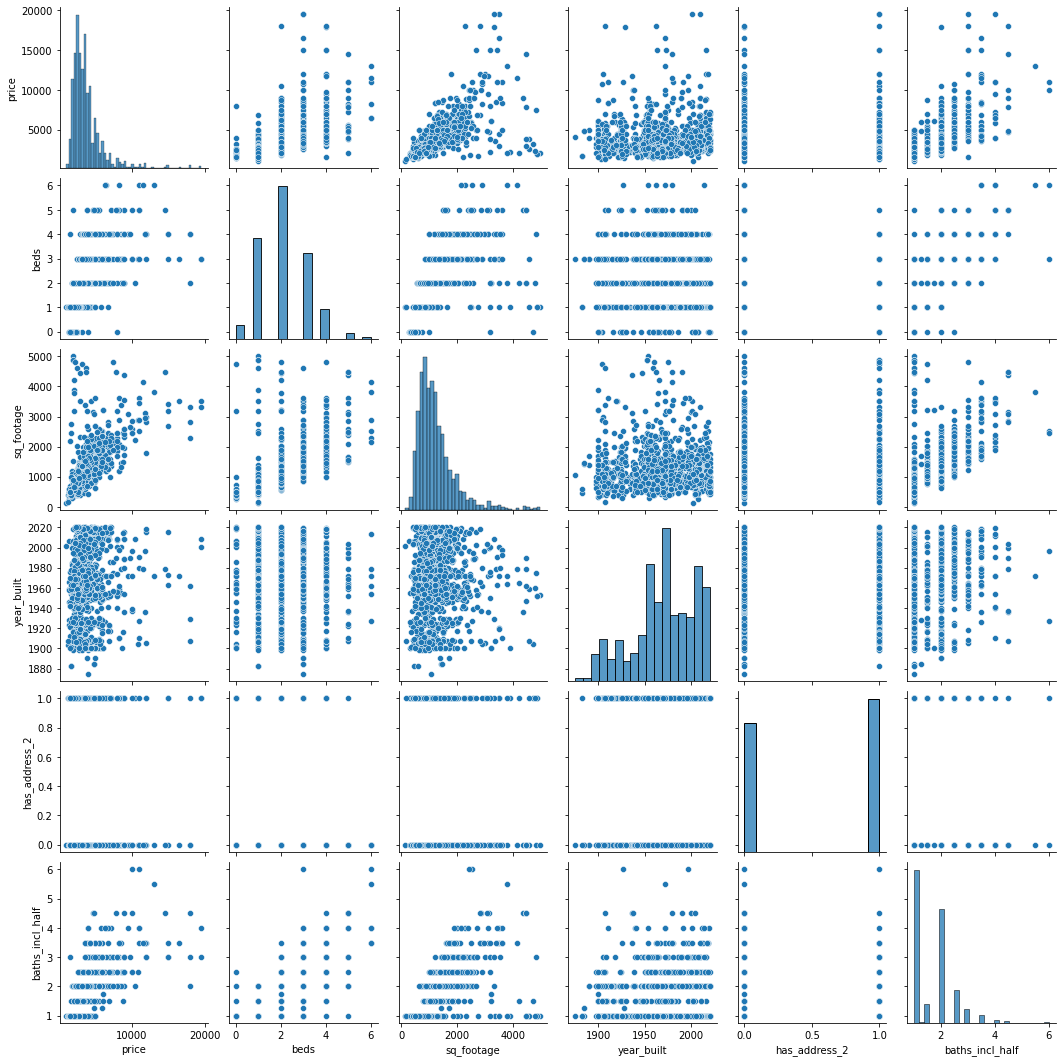

In [72]:
sns.pairplot(data = df_clean[['price','beds', 'sq_footage', 'year_built', 
                              'has_address_2', 'baths_incl_half','laundry_type','clean_mls_types']])